In [0]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import RandomForestRegressor


from tqdm import tqdm, tqdm_notebook

import quandl

import time

import warnings
warnings.filterwarnings('ignore')

seed = 11

In [3]:
# Update to master to address ValueError in ExponentialSmoothing module
!pip install git+https://github.com/statsmodels/statsmodels

  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-u2dj4hgz
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-u2dj4hgz
  Stored in directory: /tmp/pip-ephem-wheel-cache-s630f5f5/wheels/7d/ad/45/ac1a03bd759c2fa74c486e2b1950d94b55f511b4c2b0418bd5
Successfully built statsmodels


In [4]:
# statsmodels.sm problem
!pip install scipy==1.2.1

In [5]:
!pip install quandl

In [0]:
np.random.seed(seed)

In [0]:
ts_df = quandl.get("FRED/DFF", authtoken="MHASo5sqBFCvT5s55CxJ")

In [8]:
ts_df.tail()

,Value
Date,
2019-05-23,2.38
2019-05-24,2.38
2019-05-25,2.38
2019-05-26,2.38
2019-05-27,2.38


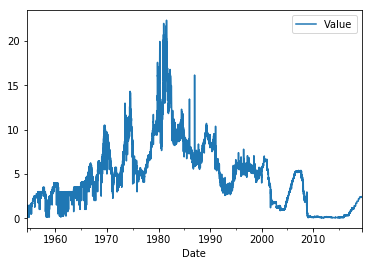

In [9]:
ts_df.plot();

In [0]:
def create_lagged_dataset(dataset, lag=1):
    df = pd.DataFrame(dataset)
    for i in range(lag):
        new_feature = df.T.tail(1).T.shift(-1)
        df = pd.concat((df, new_feature), axis=1)
    dataX = df.values[:len(dataset) - lag,:-1]
    dataY = df.values[:len(dataset) - lag,-1]
    return dataX, dataY

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return (np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
def checkEqual(iterator):
   return len(set(iterator)) <= 1

In [0]:
# M4 competition dataset
df = pd.read_csv("Monthly-train.csv")

In [14]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V2756,V2757,V2758,V2759,V2760,V2761,V2762,V2763,V2764,V2765,V2766,V2767,V2768,V2769,V2770,V2771,V2772,V2773,V2774,V2775,V2776,V2777,V2778,V2779,V2780,V2781,V2782,V2783,V2784,V2785,V2786,V2787,V2788,V2789,V2790,V2791,V2792,V2793,V2794,V2795
0,M1,8000.0,8350.0,8570.0,7700.0,7080.0,6520.0,6070.0,6650.0,6830.0,5710.0,5260.0,5470.0,7870.0,7360.0,8470.0,7880.0,6750.0,6860.0,6220.0,6650.0,5450.0,5280.0,4970.0,5550.0,7750.0,7760.0,7190.0,7440.0,6590.0,6210.0,6010.0,6390.0,5780.0,5700.0,4680.0,4970.0,6850.0,6740.0,7490.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M2,2440.0,2490.0,2710.0,2290.0,1960.0,1990.0,1960.0,2530.0,2640.0,2650.0,2150.0,1910.0,2510.0,2100.0,1840.0,2330.0,1830.0,2290.0,2090.0,2340.0,2420.0,1850.0,1960.0,2000.0,2300.0,2160.0,1730.0,2090.0,1890.0,2180.0,1950.0,2020.0,1770.0,1960.0,1860.0,1340.0,2150.0,2180.0,2030.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M3,2670.0,2590.0,2784.0,2816.0,2888.0,2906.0,2839.0,2860.0,2798.0,2795.0,2796.0,2858.0,2782.0,2801.0,2907.0,2919.0,2937.0,2878.0,2841.0,2967.0,3050.0,2981.0,3076.0,3033.0,2936.0,2927.0,2929.0,2987.0,2777.0,2760.0,2769.0,2830.0,2861.0,2991.0,3063.0,3134.0,3020.0,2947.0,3026.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M4,7264.0,7215.0,7022.0,7040.0,6966.0,6984.0,7025.0,7082.0,6956.0,7014.0,7067.0,7099.0,7046.0,7139.0,7011.0,7022.0,7084.0,7036.0,7098.0,7083.0,7045.0,7057.0,6986.0,6937.0,6927.0,6953.0,7007.0,6949.0,6930.0,6925.0,6956.0,6946.0,6866.0,6814.0,6806.0,6806.0,6855.0,6951.0,6898.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M5,4210.0,4290.0,4250.0,4320.0,4320.0,4330.0,4320.0,4260.0,4220.0,4260.0,4180.0,4230.0,4270.0,4500.0,4410.0,4440.0,4430.0,4440.0,4540.0,4450.0,4420.0,4410.0,4300.0,4300.0,4420.0,4350.0,4340.0,4410.0,4340.0,4400.0,4360.0,4420.0,4470.0,4310.0,4280.0,4220.0,4190.0,4120.0,4150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


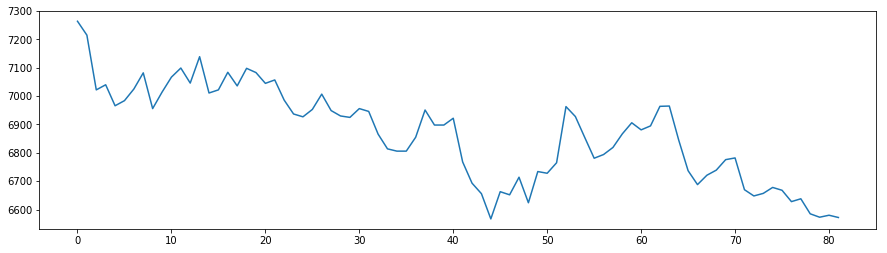

In [15]:
plt.figure(figsize=(15,4))
x = df[3:4].values[0][1:]
x = np.array(x, dtype=float)
x = x[~np.isnan(x)]
plt.plot(x);

In [0]:
gammas=np.arange(0, 1.02, 0.02)

### RandomForest

In [0]:
# for RandomForest

def validate_gamma(lags, n_splits, ts, gamma_test_part = 6, gammas=np.arange(0, 1.02, 0.02)):
    ts_gamma_train = ts.values[: (gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part)]
    ts_gamma_test = ts.values[(gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part):]
    
    res_mape = {}
    tscv = TimeSeriesSplit(n_splits=n_splits)
    gammas_best = []
    i = -1

    for lag in lags:
        mapes = []
        y_hat_cum = np.array([])
        y_test_cum = np.array([])
        for train_index, test_index in tscv.split(ts_gamma_train):
            ts_train, ts_test = ts_gamma_train[train_index], ts_gamma_train[test_index]

            # train test
            X_train, y_train = create_lagged_dataset(ts_train, lag=lag)
            X_test, y_test = create_lagged_dataset(ts_test, lag=lag)
            model = RandomForestRegressor(random_state=seed)
            model.fit(X_train,y_train)
            y_hat = model.predict(X_test)
            
            # saving results on each fold
            y_hat_cum = np.append(y_hat_cum, y_hat)
            y_test_cum = np.append(y_test_cum, y_test)
            mapes.append(mean_absolute_percentage_error(y_test, y_hat))
        
#         print('lag =' ,lag)
#         print(mean_absolute_percentage_error(y_test_cum, y_hat_cum))

        # weighting of observations
        for gamma in gammas:
            powers = np.arange(len(y_test_cum))[::-1]
            gammas_pow = np.ones(len(y_test_cum)) * gamma
            res_mape[str(gamma) + "_" + str(lag)] = np.mean(np.power(gammas_pow, powers) * mean_absolute_percentage_error(y_test_cum, y_hat_cum))
            
    i = -1
    for gamma in gammas:
        i += 1
        lowest_mape = 10**10
        gammas_best.append(-1)
        for lag in lags:
            if res_mape[str(gamma) + "_" + str(lag)] < lowest_mape:
                lowest_mape = res_mape[str(gamma) + "_" + str(lag)]
                gammas_best[i] = lag
            
            
    mapes_for_gammas = []
    best_gamma = None
    if len(np.unique(gammas_best)) == 1:
        best_gamma = "same_results_all_models"
    else:
        for gamma_best in gammas_best:
            X_train, y_train = create_lagged_dataset(ts_gamma_train, lag=gamma_best)
            X_test, y_test = create_lagged_dataset(ts_gamma_test, lag=gamma_best)
            model = RandomForestRegressor(random_state=seed)
            model.fit(X_train, y_train)
            
            y_hat = model.predict(X_test)
            mapes_for_gammas.append(np.mean(mean_absolute_percentage_error(y_test, y_hat)))
        
        best_gamma = gammas[np.argmin(mapes_for_gammas)]
    
    if best_gamma != "same_results_all_models":
        if gammas_best[np.argmin(mapes_for_gammas)] == gammas_best[-1]:
            best_gamma = "gamma_1_is_ok"
    return res_mape, gammas_best , best_gamma
            
    
            

In [0]:
start = time.time()
validate_gamma([1,2,3], 5, pd.DataFrame(x))
end = time.time()
print("Elapsed time:", end - start)


In [0]:
validate_gamma(np.arange(1, x.shape[0] // 10, 4), 5, pd.DataFrame(x))

In [47]:
hist = []
for i in tqdm_notebook(np.random.choice(47998, size = 100)):
    x = df[i:i+1].values[0][1:]
    x = np.array(x, dtype=float)
    x = x[~np.isnan(x)] 
    _, _, best_gamma = validate_gamma(np.arange(1, x.shape[0] // 10, 5), 6, pd.DataFrame(x))
    hist.append(best_gamma)

In [0]:
unique, counts = np.unique(hist, return_counts = True)

In [0]:
result = list(zip(unique, counts))

In [50]:
result

[('0.0', 16),
 ('0.04', 1),
 ('0.2', 1),
 ('0.26', 1),
 ('0.7000000000000001', 1),
 ('0.84', 1),
 ('0.86', 1),
 ('0.98', 1),
 ('gamma_1_is_ok', 27),
 ('same_results_all_models', 50)]

In [0]:
gammas_victory = 0
for i in range(len(result) - 2):
  gammas_victory += result[i][1]

In [0]:
x = ["gamma '< 1' is better than '1'", "gamma '1' isn't worse than '< 1'", "same model for all gammas"]
y = []
y.append(gammas_victory)
y.append(counts[-2])
y.append(counts[-1])

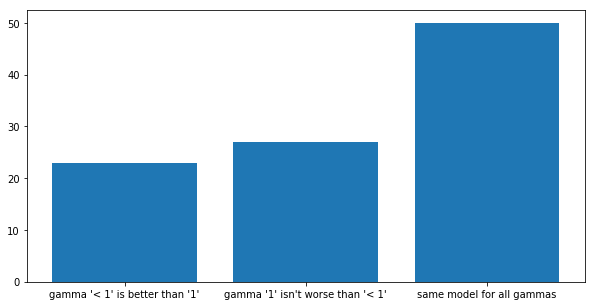

In [53]:
plt.figure(figsize=(10,5))
plt.bar(x, y);

### ARIMA

In [0]:
# source : https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [40]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [0]:
for param in pdq:
  for param_seasonal in seasonal_pdq:
    mod = sm.tsa.statespace.SARIMAX(ts_df,
                                    order=param,
                                    seasonal_order=param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()

    print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))


In [0]:
mod = sm.tsa.statespace.SARIMAX(ts_df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

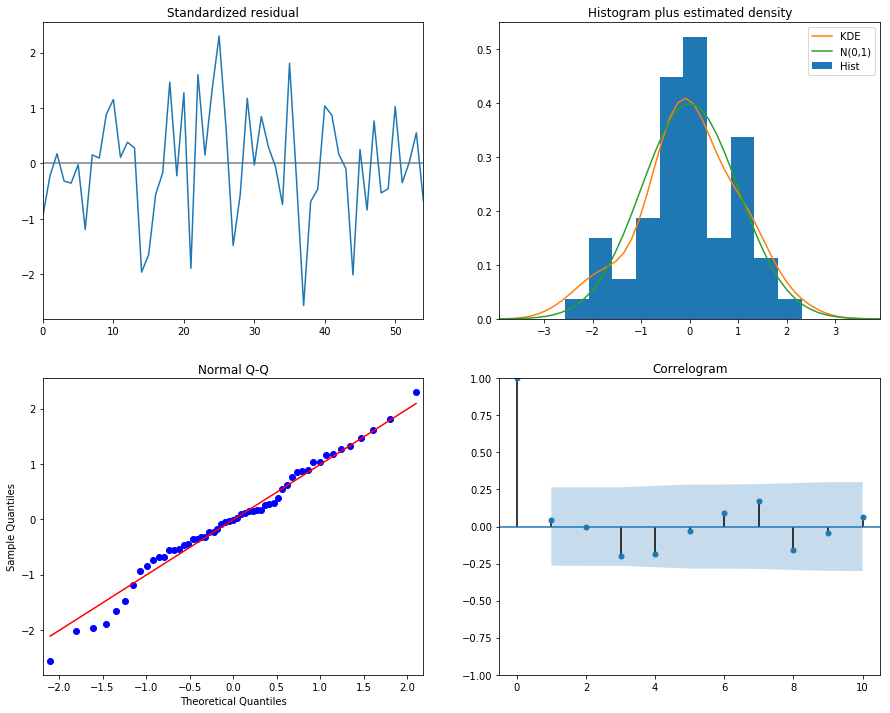

In [0]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [0]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=10)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [0]:
y = pd.Series(x)

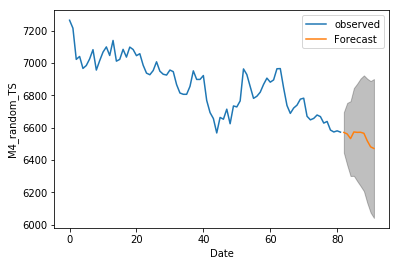

In [0]:
plt.plot(y,label='observed')
plt.plot(pred_uc.predicted_mean, label='Forecast')
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('M4_random_TS')

plt.legend()
plt.show()

In [0]:
# for ARIMA

def validate_gamma(pdq, seasonal_pdq, n_splits, ts, gamma_test_part = 6, gammas=np.arange(0, 1.02, 0.02)):
    ts_gamma_train = ts.values[: (gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part)]
    ts_gamma_test = ts.values[(gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part):]
    
    res_mape = {}
    tscv = TimeSeriesSplit(n_splits=n_splits)
    gammas_best = []
    i = -1

    for param in pdq:
#       print(param)
      for param_seasonal in seasonal_pdq:
        mapes = []
        y_hat_cum = np.array([])
        y_test_cum = np.array([])
        for train_index, test_index in tscv.split(ts_gamma_train):
#           print("!")
          ts_train, y_test = ts_gamma_train[train_index], ts_gamma_train[test_index]


          model = sm.tsa.statespace.SARIMAX(ts_train,
                              order=param,
                              seasonal_order=param_seasonal,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
          results = model.fit()
          y_hat = results.get_forecast(steps=len(y_test)).predicted_mean

          # saving results on each fold
          y_hat_cum = np.append(y_hat_cum, y_hat)
          y_test_cum = np.append(y_test_cum, y_test)
          mapes.append(mean_absolute_percentage_error(y_test, y_hat))

        # weighting of observations
        for gamma in gammas:
            powers = np.arange(len(y_test_cum))[::-1]
            gammas_pow = np.ones(len(y_test_cum)) * gamma
            res_mape[str(gamma) + "_" + str(param) + "_" + str(param_seasonal)] = np.mean(np.power(gammas_pow, powers) * mean_absolute_percentage_error(y_test_cum, y_hat_cum))

#     print(res_mape)
    i = -1
    for gamma in gammas:
        i += 1
        lowest_mape = 10**10
        gammas_best.append(-1)
        for param in pdq:
          for param_seasonal in seasonal_pdq:
              if res_mape[str(gamma) + "_" + str(param) + "_" + str(param_seasonal)] < lowest_mape:
                  lowest_mape = res_mape[str(gamma) + "_" + str(param) + "_" + str(param_seasonal)]
                  gammas_best[i] = param
            
            
    mapes_for_gammas = []
    best_gamma = None
    if checkEqual(gammas_best):
        best_gamma = "same_results_all_models"
    else:
        for gamma_best in gammas_best:
            model = sm.tsa.statespace.SARIMAX(ts_gamma_train,
                              order=gamma_best,
                              seasonal_order=param_seasonal,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
            
            
            results = model.fit()
            y_hat = results.get_forecast(steps=len(ts_gamma_test)).predicted_mean

            mapes_for_gammas.append(np.mean(mean_absolute_percentage_error(y_test, y_hat)))
        
        best_gamma = gammas[np.argmin(mapes_for_gammas)]
    
    if best_gamma != "same_results_all_models":
          if gammas_best[np.argmin(mapes_for_gammas)] == gammas_best[-1]:
              best_gamma = "gamma_1_is_ok"
    return res_mape , gammas_best , best_gamma
            
    
            

In [0]:
validate_gamma(pdq, [(0, 0, 0, 12)], 5, ts_df)

In [14]:
hist = []


p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

for i in tqdm_notebook(np.random.choice(47998, size = 1000)):
    x = df[i:i+1].values[0][1:]
    x = np.array(x, dtype=float)
    x = x[~np.isnan(x)] 
    try:
      _, _, best_gamma = validate_gamma(pdq, [(0, 0, 0, 12)], 5, pd.DataFrame(x))
    except:
      continue
    hist.append(best_gamma)

In [0]:
unique, counts = np.unique(hist, return_counts = True)

In [0]:
result = list(zip(unique, counts))

In [28]:
result

[('0.0', 242),
 ('0.16', 1),
 ('0.22', 1),
 ('0.24', 1),
 ('0.28', 1),
 ('0.32', 1),
 ('0.34', 1),
 ('0.36', 2),
 ('0.38', 3),
 ('0.4', 2),
 ('0.42', 3),
 ('0.46', 2),
 ('0.48', 4),
 ('0.5', 1),
 ('0.52', 4),
 ('0.54', 4),
 ('0.56', 10),
 ('0.58', 2),
 ('0.6', 4),
 ('0.64', 2),
 ('0.66', 4),
 ('0.68', 2),
 ('0.7000000000000001', 6),
 ('0.72', 1),
 ('0.74', 5),
 ('0.76', 4),
 ('0.78', 4),
 ('0.8', 5),
 ('0.8200000000000001', 7),
 ('0.84', 6),
 ('0.86', 3),
 ('0.88', 8),
 ('0.9', 5),
 ('0.92', 13),
 ('0.9400000000000001', 14),
 ('0.96', 16),
 ('0.98', 19),
 ('gamma_1_is_ok', 391),
 ('same_results_all_models', 196)]

In [0]:
gammas_victory = 0
for i in range(len(result) - 2):
  gammas_victory += result[i][1]

In [38]:
counts

array([242,   1,   1,   1,   1,   1,   1,   2,   3,   2,   3,   2,   4,
         1,   4,   4,  10,   2,   4,   2,   4,   2,   6,   1,   5,   4,
         4,   5,   7,   6,   3,   8,   5,  13,  14,  16,  19, 391, 196])

In [0]:
x = ["gamma '< 1' is better than '1'", "gamma '1' isn't worse than '< 1'", "same model for all gammas"]
y = []
y.append(gammas_victory)
y.append(counts[-2])
y.append(counts[-1])

In [43]:
sum(y)

1000

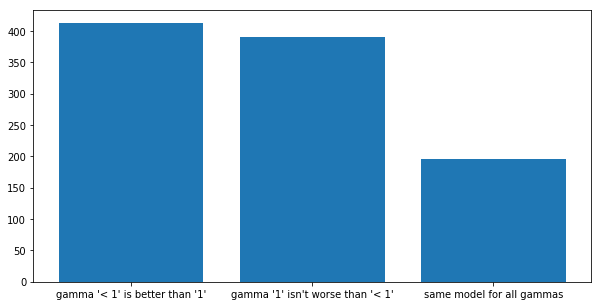

In [42]:
plt.figure(figsize=(10,5))
plt.bar(x, y);

### ETS

In [0]:
x = pd.DataFrame(x)

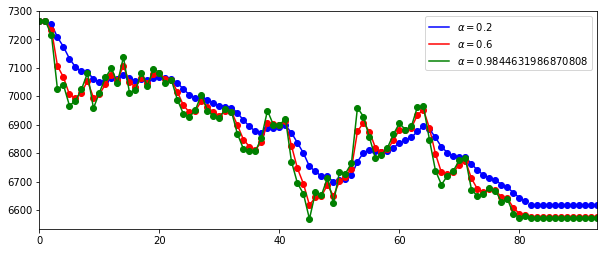

In [0]:
# source : https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1

plt.figure(figsize=(10, 4))

# Simple Exponential Smoothing
fit1 = SimpleExpSmoothing(x).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.2$')
# plot
fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(marker='o',  color='blue')



fit2 = SimpleExpSmoothing(x).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(12).rename(r'$\alpha=0.6$')
# plot
fcast2.plot(marker='o', color='red', legend=True)
fit2.fittedvalues.plot(marker='o', color='red')


fit3 = SimpleExpSmoothing(x).fit()
fcast3 = fit3.forecast(12).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
# plot
fcast3.plot(marker='o', color='green', legend=True)
fit3.fittedvalues.plot(marker='o', color='green')

plt.show()

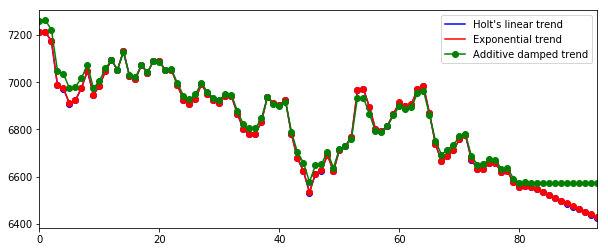

In [0]:
plt.figure(figsize=(10, 4))

fit1 = Holt(x).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")

fit2 = Holt(x, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast2 = fit2.forecast(12).rename("Exponential trend")

fit3 = Holt(x, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(12).rename("Additive damped trend")


fit1.fittedvalues.plot(marker="o", color='blue')
fcast1.plot(color='blue', marker="o", legend=True)
fit2.fittedvalues.plot(marker="o", color='red')
fcast2.plot(color='red', marker="o", legend=True)
fit3.fittedvalues.plot(marker="o", color='green')
fcast3.plot(color='green', marker="o", legend=True)

plt.show()

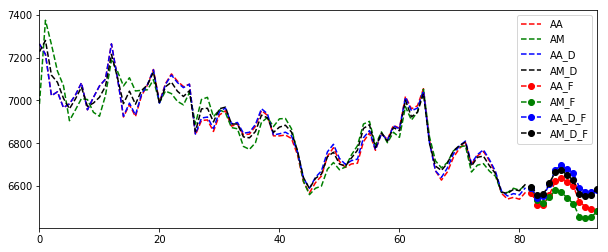

In [0]:
plt.figure(figsize=(10, 4))

fit1 = ExponentialSmoothing(x, seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(x, seasonal_periods=12, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(x, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(x, seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
fit1.fittedvalues.plot(style='--', color='red',  label="AA")
fit2.fittedvalues.plot(style='--', color='green', label="AM")
fit3.fittedvalues.plot(style='--', color='blue', label="AA_D")
fit4.fittedvalues.plot(style='--', color='black', label="AM_D")


fit1.forecast(12).plot(style='--', marker='o', color='red',label="AA_F")
fit2.forecast(12).plot(style='--', marker='o', color='green', label="AM_F")
fit3.forecast(12).plot(style='--', marker='o', color='blue',label="AA_D_F")
fit4.forecast(12).plot(style='--', marker='o', color='black', label="AM_D_F")
plt.legend()


plt.show()